# Part 1: setup

#### Import libraries

In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Import dataset

In [2]:
url20 = "https://zenodo.org/records/8303397/files/full_data_20.csv?download=1"
url60 = "https://zenodo.org/records/8303397/files/full_data_60.csv?download=1"
url80 = "https://zenodo.org/records/8303397/files/full_data_80.csv?download=1"

gamesAt20 = pd.read_csv(url20 , sep=',')
gamesAt60 = pd.read_csv(url60 , sep=',')
gamesAt80 = pd.read_csv(url80 , sep=',')

gamesAt20_no_clean = gamesAt20.copy()

backup = gamesAt20.copy()
backup60 = gamesAt60.copy()
backup80 = gamesAt80.copy()

#### reset data

In [91]:
# reset the dataset using backup

gamesAt20 = backup.copy()
gamesAt60 = backup60.copy()
gamesAt80 = backup80.copy()
gamesAt20_no_clean = gamesAt20.copy()

#### Check for empty cells

In [92]:
gamesAt20.isna().sum()

Unnamed: 0                 0
matchID                    0
fullTimeMS                 0
timePercent                0
blueChampionKill           0
blueFirstBlood             0
blueDragonKill             0
blueDragonHextechKill      0
blueDragonChemtechKill     0
blueDragonFireKill         0
blueDragonAirKill          0
blueDragonEarthKill        0
blueDragonWaterKill        0
blueDragonElderKill        0
blueRiftHeraldKill         0
blueBaronKill              0
blueTowerKill              0
blueInhibitorKill          0
blueTotalGold              0
blueMinionsKilled          0
blueJungleMinionsKilled    0
blueAvgPlayerLevel         0
blueWin                    0
redChampionKill            0
redFirstBlood              0
redDragonKill              0
redDragonHextechKill       0
redDragonChemtechKill      0
redDragonFireKill          0
redDragonAirKill           0
redDragonEarthKill         0
redDragonWaterKill         0
redDragonElderKill         0
redRiftHeraldKill          0
redBaronKill  

In [93]:
(gamesAt20.values == '?').sum()

0

# Part 2: Clean the data

### Unused data
There are 2 features we can remove easily. The features are matchID and Unnamed.
We believe that Unnamed is a index counter, matchID is self explanatory.

In [94]:
gamesAt20.drop(labels=['Unnamed: 0' , 'matchID'] , axis=1 , inplace=True)
gamesAt60.drop(labels=['Unnamed: 0' , 'matchID'] , axis=1 , inplace=True)
gamesAt80.drop(labels=['Unnamed: 0' , 'matchID'] , axis=1 , inplace=True)
gamesAt20_no_clean.drop(labels=['Unnamed: 0' , 'matchID'] , axis=1 , inplace=True)

### Redundant data
Boolean columns like red/blue first blood and red/blue win are boolean and redundant, if one is true for red then it must be false for blue.
Moving forward we will drop red team boolean variables

In [95]:
gamesAt20['blueFirstBlood'] = gamesAt20['blueFirstBlood'].astype(int)
gamesAt20['blueWin'] = gamesAt20['blueWin'].astype(int)

gamesAt20.drop(labels=['redFirstBlood' , 'redWin'] , axis=1 , inplace=True)

gamesAt60['blueFirstBlood'] = gamesAt60['blueFirstBlood'].astype(int)
gamesAt60['blueWin'] = gamesAt60['blueWin'].astype(int)

gamesAt60.drop(labels=['redFirstBlood' , 'redWin'] , axis=1 , inplace=True)

gamesAt80['blueFirstBlood'] = gamesAt80['blueFirstBlood'].astype(int)
gamesAt80['blueWin'] = gamesAt80['blueWin'].astype(int)

gamesAt80.drop(labels=['redFirstBlood' , 'redWin'] , axis=1 , inplace=True)

### Extreme edge cases  

Furthermore since we are only at 20% of the game it is nearly impossible that inhibitors and towers have been destroyed, therefore we can safely remove them.
More features we can safely remove are baron kills and elder kills since baron spawns at 20 minutes, and the elder dragon spawns 5 minutes after one team has claimed 4 dragons, and each dragon is on a 5 minute respawn timer. This means that at a minimum it takes 25 minutes for elder to spawn. For these values to be greater than 0 that means the game must last for over 100 minutes, and since the average game time is 25-45 minutes the 100 minute+ game is a clear outlier that we can discard. Further into the game these metrics become more important so we will leave them in for data at longer timestamps.

In [96]:
gamesAt20.drop(labels=['blueBaronKill' , 'redBaronKill' , 'blueTowerKill' , 'redTowerKill' , 'blueDragonElderKill' , 'redDragonElderKill' , 'blueInhibitorKill' , 'redInhibitorKill'] , axis=1 , inplace=True)

### Inting, remakes, and FF

There are cases where a player may lave left the game early and the game can be "remade" or FF(forfeited) early, these games still have a win/loss outcome but we need to remove them since nothing actually happened in the game. To predict the outcome of these games is outside of the scope of this project.

There are cases where one or more players may be intentionally losing or a team may have just given up resulting in a FF, these games obviously need to be removed. This dataset lacks the features to properly detect inting but we can remove the games that are forfeited to remove enough of them.

To determine remade games we can simply compare the gold of each team, if they are the same then the game is remade. We will instead use a time cutoff since that will encompass the games with equal gold

In [97]:
# this is what we would have done to remove games that were known to be remakes
# gamesAt20.drop(gamesAt20[gamesAt20['blueTotalGold'] == gamesAt20['redTotalGold']].index , inplace=True)


To determine forfeited games we can cutoff all games that run for less than 17 minutes, 15 minutes is when the regular FF vote opens and we have 2 minute to allow for players to vote to end the game.
Let's look at a graph of the frequency of how long a game lasts.

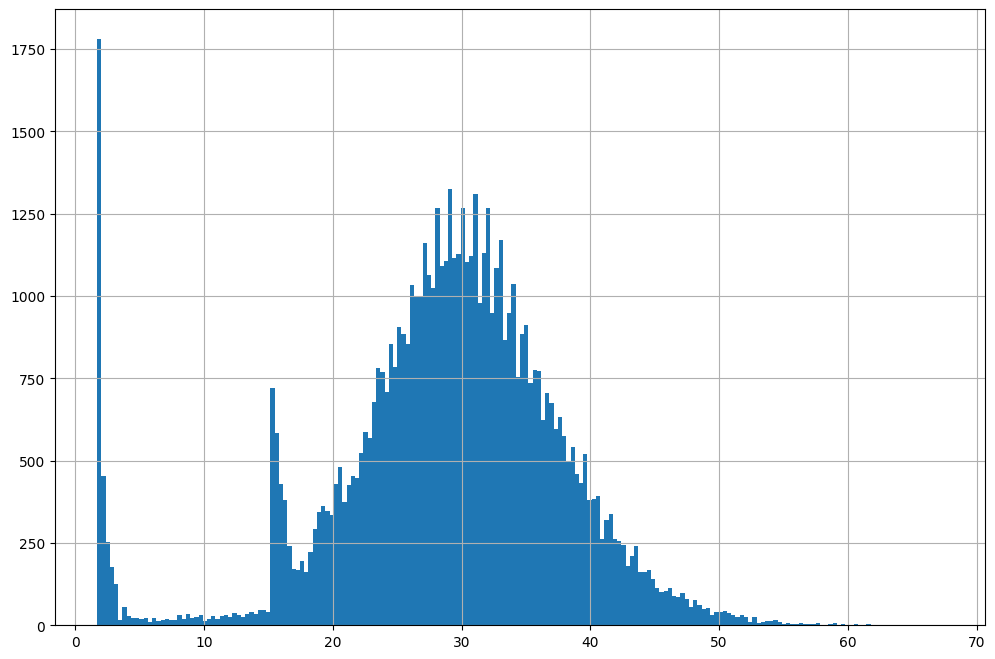

In [98]:
# add a column for the game time in minutes (for easier analysis)

gamesAt20['fullTimeMin'] = gamesAt20['fullTimeMS'] / 60000

# show the distribution of the game time
# this graph is will be the same across all our datasets

gamesAt20['fullTimeMin'].hist(bins = 200 , figsize=(12 , 8))
plt.show()

Notice there are two massive spikes from the distribution, the first one occurs before 5 minutes, these games are all remake. The second massive spike occurs just after 15 minutes, this is when the regular FF vote opens and games are forfeited, the games inbetween these two spikes are early FF votes. From this we can conclude every game before 17 minutes can be safely ignored.

In [99]:
gamesAt20.drop(gamesAt20[gamesAt20['fullTimeMS'] < 1020000].index , inplace=True)
gamesAt60.drop(gamesAt60[gamesAt60['fullTimeMS'] < 1020000].index , inplace=True)
gamesAt80.drop(gamesAt80[gamesAt80['fullTimeMS'] < 1020000].index , inplace=True)

In [100]:
gamesAt20['timePercent'].describe()

count    58344.000000
mean         5.674979
std          1.377235
min          3.000000
25%          5.000000
50%          6.000000
75%          7.000000
max         13.000000
Name: timePercent, dtype: float64

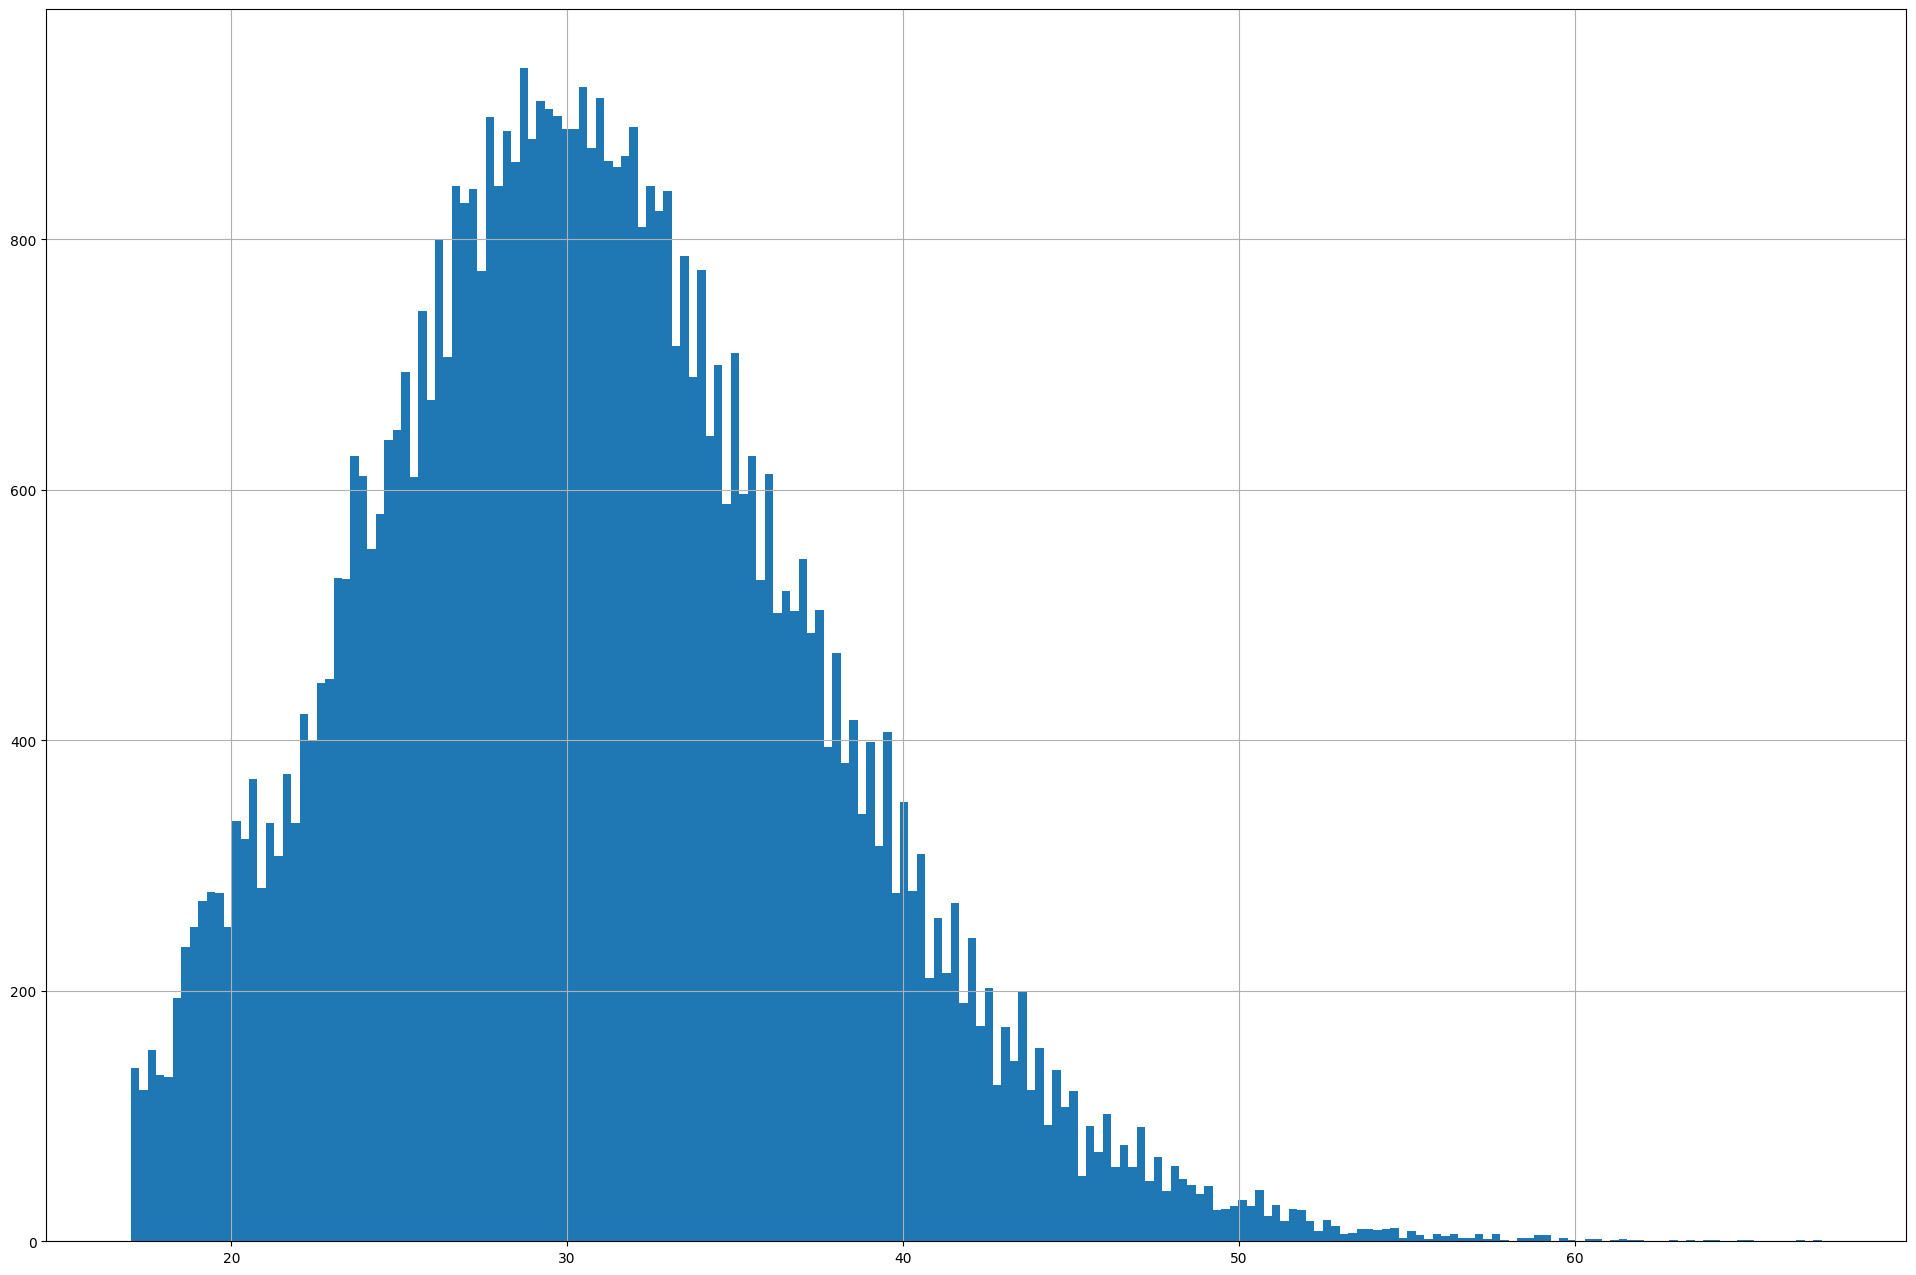

In [101]:
# this graph will be the same across all our datasets

gamesAt20['fullTimeMin'].hist(bins = 200 , figsize=(24 , 16))
plt.show()

### Refined graphs

These graphs are much better, however some values are stull bound at either 1 or 0, most are regarding neutral objectives. At this point in the game it is highly unlikely that any neutral objective will have been claimed so we should be able to safely remove these data points, but we will determine how much the actually matter first.

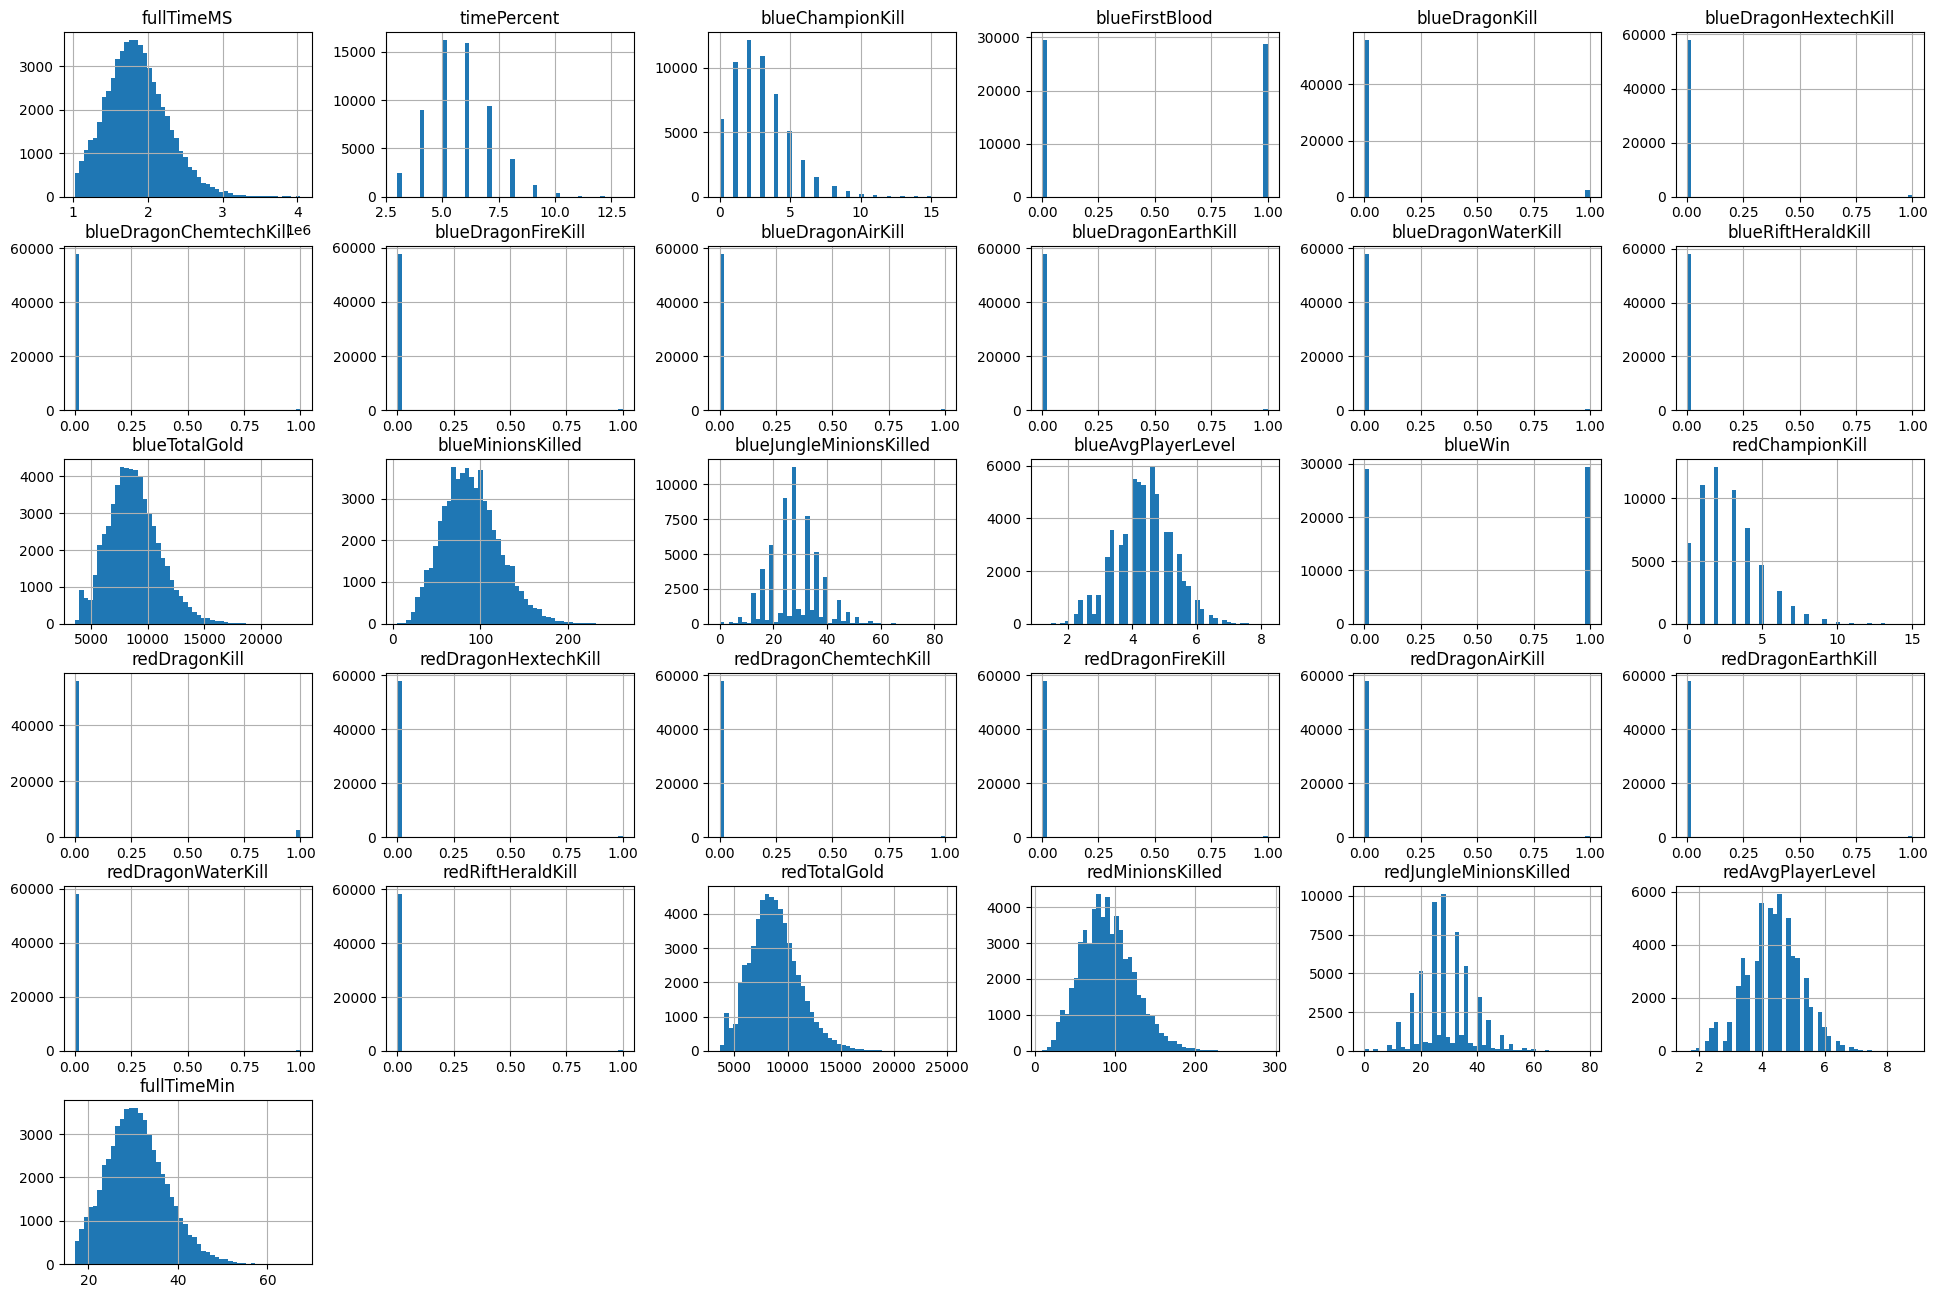

In [102]:
gamesAt20.hist(bins = 50 , figsize=(24 , 16))
plt.show()

# gamesAt60.hist(bins = 50 , figsize=(24 , 16))
# plt.show()

# gamesAt80.hist(bins = 50 , figsize=(24 , 16))
# plt.show()

#### Let's compare the importance of claiming a neutral objective (dragon or herald) versus the importance of the other features

##### Correlations

We should note that __in general__ when the correlation is negative it just means that the absolute value of that negative corelation would be the corelation for the feature redWin (which has been removed since it is just the opposite of blueWin).

In [103]:
corr_matrix2 = gamesAt20.corr(numeric_only=True)
corr_matrix6 = gamesAt60.corr(numeric_only=True)
corr_matrix8 = gamesAt80.corr(numeric_only=True)

In [104]:
corr_matrix2['blueWin'].reindex(gamesAt20.columns.tolist())

fullTimeMS                -0.011774
timePercent               -0.011214
blueChampionKill           0.105451
blueFirstBlood             0.133817
blueDragonKill             0.015183
blueDragonHextechKill      0.003662
blueDragonChemtechKill     0.007767
blueDragonFireKill         0.001223
blueDragonAirKill          0.003174
blueDragonEarthKill        0.018041
blueDragonWaterKill        0.003471
blueRiftHeraldKill        -0.002083
blueTotalGold              0.051790
blueMinionsKilled          0.028707
blueJungleMinionsKilled    0.032207
blueAvgPlayerLevel         0.017865
blueWin                    1.000000
redChampionKill           -0.117783
redDragonKill             -0.027200
redDragonHextechKill      -0.015304
redDragonChemtechKill     -0.012828
redDragonFireKill         -0.013398
redDragonAirKill          -0.012692
redDragonEarthKill        -0.004786
redDragonWaterKill        -0.006165
redRiftHeraldKill          0.005692
redTotalGold              -0.071630
redMinionsKilled          -0

Here we can see that almost all of the red team corelation are negative, which lines up with our expectations. We can also see that dragons and heralds have the least corelation, this also lines up with our expectations. Since this data is at only 20% of the game we cannot expect any useful information from these data points.

In [105]:
gamesAt20.drop(['blueDragonKill' , 'redDragonKill' , 'blueRiftHeraldKill' , 'redRiftHeraldKill' , 'blueDragonHextechKill' , 'redDragonHextechKill' , 'blueDragonChemtechKill' , 'redDragonChemtechKill' , 'blueDragonFireKill' , 'redDragonFireKill' , 'blueDragonAirKill' , 'redDragonAirKill' , 'blueDragonEarthKill' , 'redDragonEarthKill' , 'blueDragonWaterKill' , 'redDragonWaterKill'] , axis=1 , inplace=True)

#### Here are updated graphs

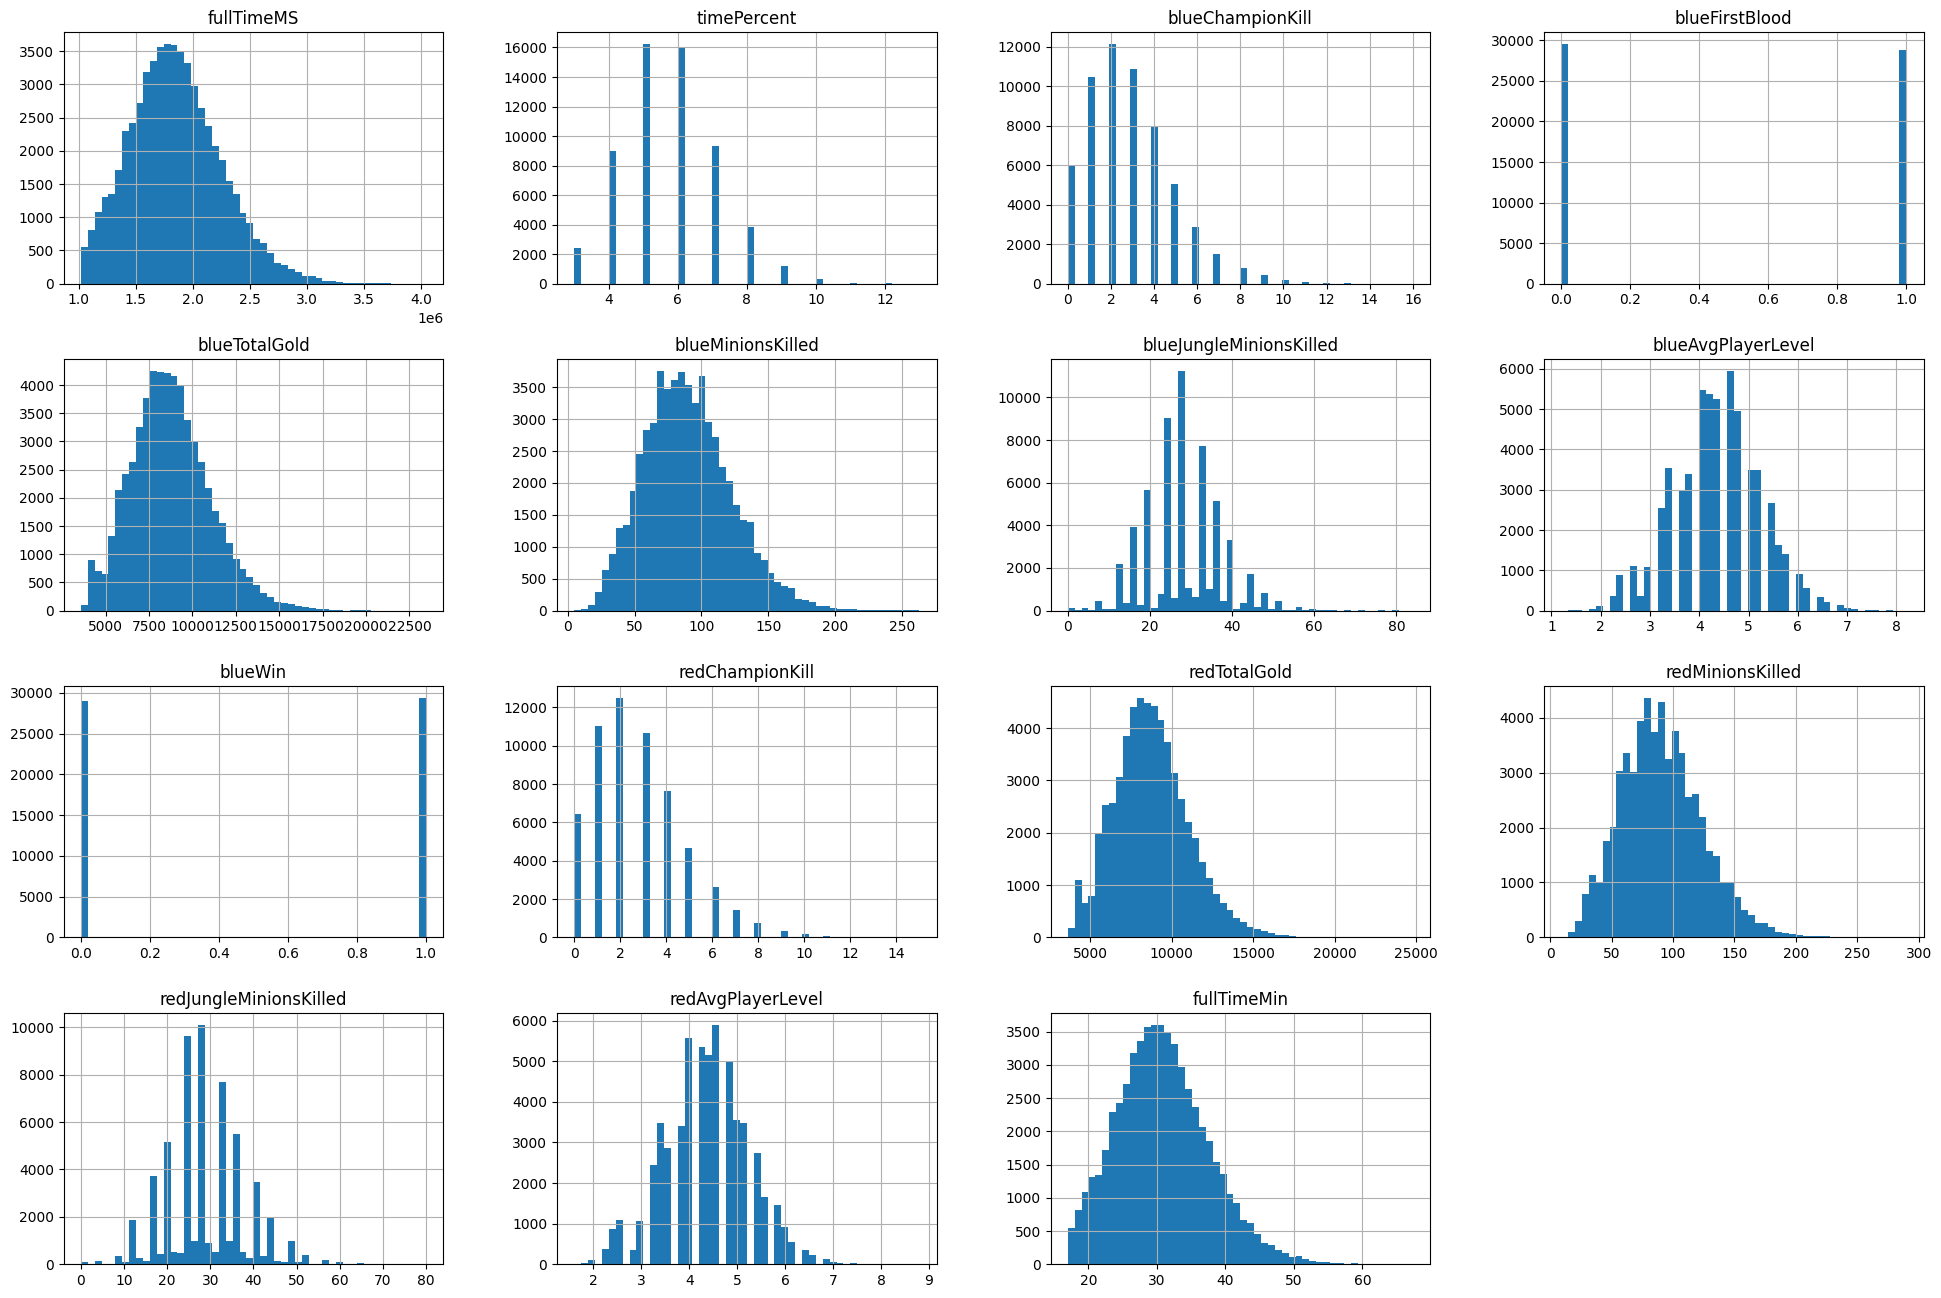

In [106]:
gamesAt20.hist(bins = 50 , figsize=(24 , 16))
plt.show()

#### Remove fullTimeMin and timePercent

These two features are for user reference only, fullTimeMin was used to determine a cutoff point and now that we are done with it we do not need it anymore.

In [107]:
# keeping the features for full game length decrease accuracy by ~10% for the 20% game time dataset

gamesAt20.drop(labels=['fullTimeMin'] , axis=1 , inplace=True)
#gamesAt60.drop(labels=['timePercent'] , axis=1 , inplace=True)
#gamesAt80.drop(labels=['timePercent'] , axis=1 , inplace=True)

In [108]:
#gamesAt20.drop(labels=['fullTimeMS'] , axis=1 , inplace=True)

# Part 3: Select and train a model

### Split the dataset into training and testing sets

In [109]:
from sklearn.model_selection import train_test_split

x = gamesAt20.drop(labels=['blueWin'] , axis=1)
y = gamesAt20['blueWin']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print(x_train.shape , y_train.shape , x_test.shape , y_test.shape)

(46675, 13) (46675,) (11669, 13) (11669,)


## Classification

### SVM Classifier - SVC - Default Hyperparameters

#### Train the model

In [110]:
from sklearn.svm import SVC

reg_svc = SVC()
reg_svc.fit(x_train , y_train)

SVC()

#### Test the model

In [111]:
from sklearn.metrics import accuracy_score , confusion_matrix , classification_report

reg_y_pred = reg_svc.predict(x_test)
print(classification_report(y_test , reg_y_pred))

              precision    recall  f1-score   support

           0       0.50      0.56      0.53      5725
           1       0.52      0.45      0.48      5944

    accuracy                           0.51     11669
   macro avg       0.51      0.51      0.51     11669
weighted avg       0.51      0.51      0.50     11669



#### Performance Metrics

purple is bad

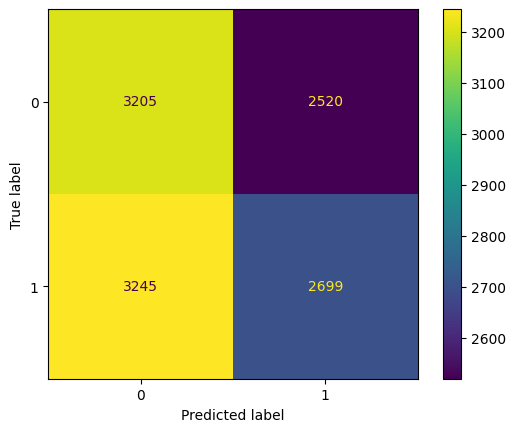

In [112]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test , reg_y_pred)
plt.show()

### SVM Classifier rbf kernel (broken)

#### Train the model

In [113]:
rbf_svc = SVC(kernel='rbf' , C=1 , gamma=1)
rbf_svc.fit(x_train , y_train)

SVC(C=1, gamma=1)

#### Test the model

In [114]:
rbf_y_pred = rbf_svc.predict(x_test)
print(classification_report(y_test , rbf_y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5725
           1       0.51      1.00      0.67      5944

    accuracy                           0.51     11669
   macro avg       0.25      0.50      0.34     11669
weighted avg       0.26      0.51      0.34     11669



c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Performance Metrics

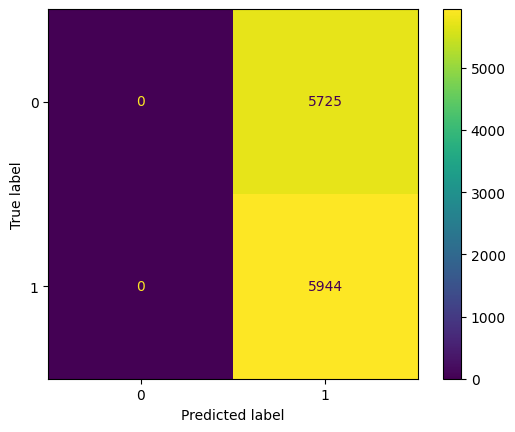

In [115]:
ConfusionMatrixDisplay.from_predictions(y_test , rbf_y_pred)
plt.show()

### Polynomial Kernel

In [116]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

poly_svc_kernel = make_pipeline(
    StandardScaler() , 
    SVC(kernel='poly' , degree=3 , C=1)
)

poly_svc_kernel.fit(x_train , y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=1, kernel='poly'))])

In [117]:
poly_svc_kernel_y_pred = poly_svc_kernel.predict(x_test)
print(classification_report(y_test , poly_svc_kernel_y_pred))

              precision    recall  f1-score   support

           0       0.59      0.62      0.61      5725
           1       0.62      0.60      0.61      5944

    accuracy                           0.61     11669
   macro avg       0.61      0.61      0.61     11669
weighted avg       0.61      0.61      0.61     11669



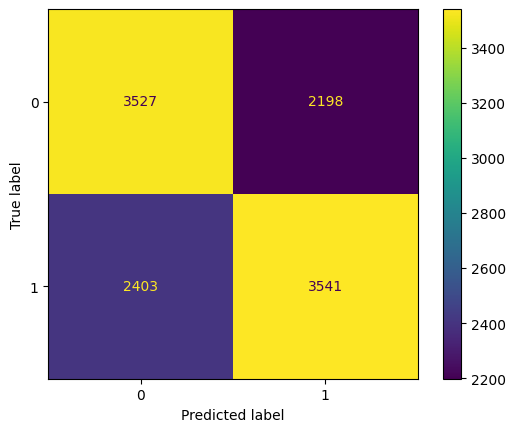

In [122]:
ConfusionMatrixDisplay.from_predictions(y_test , poly_svc_kernel_y_pred)
plt.show()

### Logistic Regression

In [118]:
from sklearn.linear_model import LogisticRegression

log_reg_svm = make_pipeline(
    StandardScaler() , 
    LogisticRegression()
)

log_reg_svm.fit(x_train , y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [119]:
log_reg_y_pred = log_reg_svm.predict(x_test)
print(classification_report(y_test , log_reg_y_pred))

              precision    recall  f1-score   support

           0       0.61      0.61      0.61      5725
           1       0.62      0.63      0.63      5944

    accuracy                           0.62     11669
   macro avg       0.62      0.62      0.62     11669
weighted avg       0.62      0.62      0.62     11669



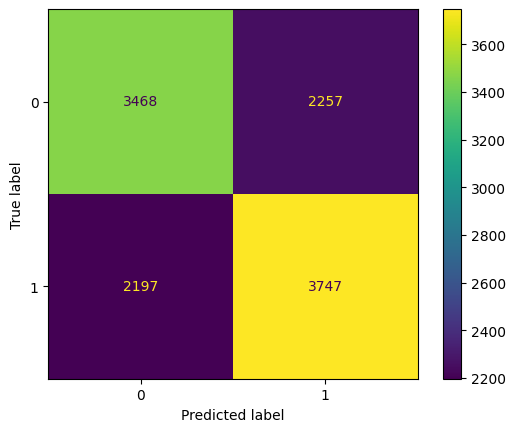

In [123]:
ConfusionMatrixDisplay.from_predictions(y_test , log_reg_y_pred)
plt.show()

### LinearSVC

In [120]:
from sklearn.svm import LinearSVC

lin_svc = make_pipeline(
    StandardScaler() , 
    LinearSVC(C=10 , random_state=42 , dual=False  , max_iter=10000)
)
lin_svc.fit(x_train , y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(C=10, dual=False, max_iter=10000, random_state=42))])

In [121]:
lin_svc_y_pred = lin_svc.predict(x_test)
print(classification_report(y_test , lin_svc_y_pred))

              precision    recall  f1-score   support

           0       0.61      0.61      0.61      5725
           1       0.62      0.63      0.63      5944

    accuracy                           0.62     11669
   macro avg       0.62      0.62      0.62     11669
weighted avg       0.62      0.62      0.62     11669



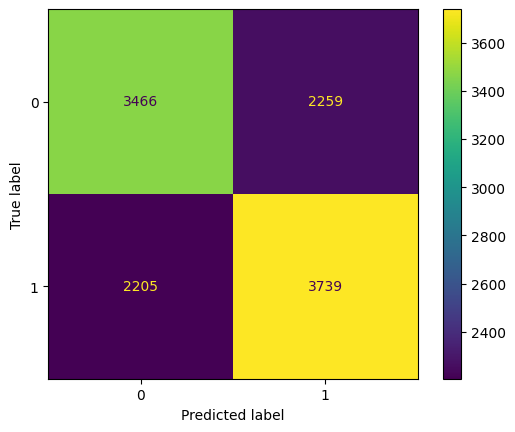

In [124]:
ConfusionMatrixDisplay.from_predictions(y_test , lin_svc_y_pred)